# Project 1: Energy Efficiency in AI- Quantization of ML models

## Object detection using SSD-mobilenet-v2 pretrained model on COCO 2017 dataset 

## Install TFlite support libraries

In [1]:
import cv2

In [2]:
!pip install -q tflite_support

     |████████████████████████████████| 60.9 MB 1.2 MB/s 
     |████████████████████████████████| 216 kB 61.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.10.26 which is incompatible.


In [ ]:
# #!pip uninstall opencv-python-headless==4.5.5.64 -y
# !pip3 install opencv-python
# import cv2

## Install TensorFlow object detection API



In [21]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
pip install -q .

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


## Import neccessary libraries

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline



/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Download the pretrained model 

In [6]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

--2022-11-23 00:41:43--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.74.128, 2607:f8b0:4001:c0d::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.74.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  --.-KB/s    in 0.1s    

2022-11-23 00:41:43 (182 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



## Transform the pretrained model to TFLite model

* 1. Export TFLite inference graph

First, we invoke export_tflite_graph_tf2.py to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

* 2. Convert to TFLite 

In [7]:
!python models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint'} \
    --output_directory {'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/tflite'} \
    --pipeline_config_path {'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config'}

2022-11-23 00:42:28.858430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-23 00:42:28.858564: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-23 00:42:28.858588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/

## Download the validation dataset of the COCO dataset so it can be feed to the quantization methods

Out of 5000 images, take 1000 to make the neccessary predictions with the quantization configurations and append them to the representative dataset.

In [8]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2022-11-23 00:44:14--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.171.73, 52.217.94.188, 52.216.229.8, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.171.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  92.3MB/s    in 8.6s    

2022-11-23 00:44:22 (90.0 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [9]:
!unzip -q val2017.zip 

In [10]:
from fnmatch import fnmatch
root = 'val2017/'
pattern = "*.jpg"
imagePaths = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            imagePaths.append(root + name)
print("first path: ",imagePaths[0])
print("length: ", len(imagePaths))

first path:  val2017/000000017115.jpg
length:  5000


In [24]:
def _representative_dataset_gen_full():
    root = 'val2017/'
    pattern = "*.jpg"
    imagePaths = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern):
                imagePaths.append(root + name)        
    for index,p in enumerate(imagePaths[:100]): 
            if index % 20 == 0:
              print(index)
            image = cv2.imread(p)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = cv2.resize(image, (640, 640)) 
            image = image.astype("float") 
            image = np.expand_dims(image, axis=1) 
            image = image.reshape(1, 640, 640, 3)
            #minus mean and devide by std
            image = (image - 127.5)/127.5
            yield [image.astype("float32")]


In [25]:
#Full integer quantization- uint8

_TFLITE_MODEL_PATH_FULL_UINT8 = "/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/model_full_uint8.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/tflite/saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.experimental_new_quantizer = True
converter.representative_dataset = _representative_dataset_gen_full
converter.inference_input_type = tf.uint8  # or tf.uint8
tflite_model = converter.convert()




with open(_TFLITE_MODEL_PATH_FULL_UINT8, 'wb') as f:
  f.write(tflite_model)

0
20
40
60
80


In [28]:
#Float16 quantization

_TFLITE_MODEL_PATH_FULL_FLOAT16 = "/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/model_full_float16.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/tflite/saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model_float16 = converter.convert()




with open(_TFLITE_MODEL_PATH_FULL_FLOAT16, 'wb') as f:
  f.write(tflite_model_float16)

In [29]:
#Float32 quantization 


_TFLITE_MODEL_PATH_FULL_FLOAT32 = "/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/model_full_float32.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/tflite/saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

tflite_model_float32 = converter.convert()




with open(_TFLITE_MODEL_PATH_FULL_FLOAT32, 'wb') as f:
  f.write(tflite_model_float32)

In [30]:
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(":", 1)[1].replace('"', '').strip()

            if item_id is not None and item_name is not None:
                items[item_name] = item_id
                item_id = None
                item_name = None

    return items


## Read the labels of the dataset and create other helper functions

In [14]:
label_map = read_label_map("/content/models/research/object_detection/data/mscoco_label_map.pbtxt")

classes = {}


for label_name,label_id in label_map.items():
    classes[label_id-1] = label_name

COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

#helper functions
def preprocess_image_cv(image_path, input_size):
        """Preprocess the input image to feed to the TFLite model"""
        image = cv2.imread(image_path)
        original_image = image.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image, (640, 640)) 
        image = (image-127.5)/127.5
        image = image * 255
        preprocessed_image = image.astype(np.uint8) 
        return preprocessed_image, original_image    


def set_input_tensor(interpreter, image):
        """Set the input tensor."""
        tensor_index = interpreter.get_input_details()[0]['index']
        input_tensor = interpreter.tensor(tensor_index)()[0]
        input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
        """Retur the output tensor at the given index."""
        output_details = interpreter.get_output_details()[index]
        tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
        return tensor


def detect_objects(interpreter, image, threshold, change_detect_order=False, debugging = False):
        """Returns a list of detection results, each a dictionary of object info."""
        # Feed the input image to the model
        set_input_tensor(interpreter, image)
        interpreter.invoke()
        
        if debugging:
          for i in range(0,4):
              print(i, get_output_tensor(interpreter, i))
        
        if change_detect_order:
            # Get all outputs from the model
            boxes = get_output_tensor(interpreter, 1)
            classes = get_output_tensor(interpreter, 3)
            scores = get_output_tensor(interpreter, 0)
            count = int(get_output_tensor(interpreter, 2))
        else:
            # Get all outputs from the model
            boxes = get_output_tensor(interpreter, 0)
            classes = get_output_tensor(interpreter, 1)
            scores = get_output_tensor(interpreter, 2)
            count = int(get_output_tensor(interpreter, 3))
        
        if debugging:
          print("scores shape", scores.shape)
          print("classes shape", classes.shape)
          print("boxes shape", boxes.shape)
          
        results = []
        for i in range(count):
            if scores[i] >= threshold:
              result = {
                'bounding_box': boxes[i],
                'class_id': classes[i],
                'score': scores[i]
              }
              results.append(result)
                
        return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5, change_detect_order = False, debugging = False):
        """Run object detection on the input image and draw the detection results"""
        # Load the input shape required by the model
        _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

        # Load the input image and preprocess it
        preprocessed_image, original_image = preprocess_image_cv(
          image_path,
          (input_height, input_width)
        )

        # Run object detection on the input image
        results = detect_objects(interpreter, preprocessed_image, 
                                 threshold=threshold,
                                 change_detect_order = change_detect_order, 
                                 debugging= debugging)

        # Plot the detection results on the input image
        #original_image_np = original_image.numpy().astype(np.uint8)
        original_image_np = original_image
        for obj in results:
            # Convert the object bounding box from relative coordinates to absolute
            # coordinates based on the original image resolution
            ymin, xmin, ymax, xmax = obj['bounding_box']
            xmin = int(xmin * original_image_np.shape[1])
            xmax = int(xmax * original_image_np.shape[1])
            ymin = int(ymin * original_image_np.shape[0])
            ymax = int(ymax * original_image_np.shape[0])

            # Find the class index of the current object
            class_id = int(obj['class_id'])

            # Draw the bounding box and label on the image
            color = [255,255,255]
            cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
            # Make adjustments to make the label visible for all objects
            y = ymin - 15 if ymin - 15 > 15 else ymin + 15
            label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
            cv2.putText(original_image_np, label, (xmin, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Return the final image
        original_uint8 = original_image_np.astype(np.uint8)
        return original_uint8


In [15]:
def test_tf_lite(interpreter, image_path, debugging = False):
  DETECTION_THRESHOLD = 0.4 #@param {type:"number"}



  # Run inference and draw detection result on the local copy of the original file
  detection_result_image = run_odt_and_draw_results(
      image_path,
      interpreter,
      threshold=DETECTION_THRESHOLD,
      change_detect_order = 1,
      debugging = debugging
  )

  # Show the detection result
  plt.imshow(cv2.cvtColor(detection_result_image, cv2.COLOR_BGR2RGB))
  #plt.figure(figsize = detection_result_image.shape*2)
  plt.show()
  #return detection_result_image

In [33]:
# Load the TFLiteUINT8 model which used the full repr data for converting
interpreter = tf.lite.Interpreter(model_path=_TFLITE_MODEL_PATH_FULL_UINT8)
interpreter.allocate_tensors()

0 [0.234375   0.1796875  0.14453125 0.10546875 0.10546875 0.09765625
 0.09765625 0.09765625 0.09765625 0.09765625]
1 [[0.32658854 0.05611679 0.8594513  0.915583  ]
 [0.45763192 0.43758085 0.5710006  0.49633417]
 [0.4638819  0.40612626 0.57725054 0.49755365]
 [0.4609599  0.46188927 0.5455525  0.49363953]
 [0.53390324 0.39989826 0.5812855  0.49297926]
 [0.45981142 0.416614   0.554576   0.4753673 ]
 [0.45630565 0.41736335 0.5788342  0.5398919 ]
 [0.36024615 0.34898633 0.5789989  0.5045987 ]
 [0.36692023 0.39287055 0.5830798  0.53684974]
 [0.07506299 0.0049448  0.4679569  0.87995577]]
2 10.0
3 [15.  0.  0.  0. 37.  0.  0. 15. 15. 15.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


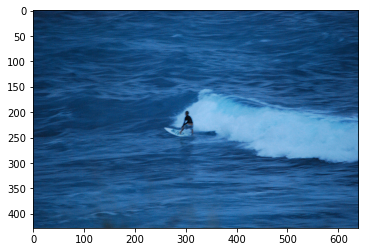

0 [0.55859375 0.53125    0.44140625 0.3046875  0.234375   0.234375
 0.21484375 0.21484375 0.21484375 0.1796875 ]
1 [[ 0.14353752  0.04379669  0.9826857   0.95620346]
 [ 0.00790712  0.02584043  0.31360283  0.36019936]
 [ 0.25239325  0.09078726  0.8898672   0.8092128 ]
 [ 0.4379328   0.7840231   0.9489557   0.8609069 ]
 [ 0.20418847 -0.00263631  0.33348638  0.16059095]
 [-0.00648279  0.04623064  0.1995773   0.33418903]
 [ 0.42474163  0.4638905   0.79483867  0.79624945]
 [ 0.43469375  0.72967947  0.9870061   0.8597554 ]
 [ 0.42264214  0.80795467  1.0054681   0.9528003 ]
 [ 0.44046772  0.8358628   0.95149064  0.9141372 ]]
2 10.0
3 [66. 46. 60. 48. 46. 46. 60. 48. 89. 48.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


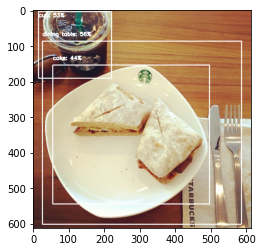

0 [0.55859375 0.46875    0.3828125  0.33203125 0.3046875  0.28125
 0.28125    0.2578125  0.2578125  0.21484375]
1 [[0.51402783 0.5212878  0.88635194 0.92852235]
 [0.4623834  0.47064847 0.9795749  0.97865206]
 [0.50778353 0.56351787 0.7991966  0.8861024 ]
 [0.07520533 0.0608654  0.9821545  0.96781456]
 [0.62697953 0.46628264 0.9798108  0.91975725]
 [0.42300358 0.22663721 0.95586634 0.94506264]
 [0.47502604 0.15997519 0.98912406 0.5256849 ]
 [0.3667409  0.12501904 0.9636787  0.63302255]
 [0.63515806 0.13640757 1.0074822  0.42095232]
 [0.56567115 0.15245295 0.7844239  0.28330204]]
2 10.0
3 [60. 60. 60. 60. 60. 60. 85. 60. 85. 52.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


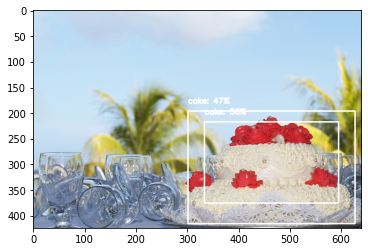

0 [0.5859375  0.44140625 0.3828125  0.35546875 0.2578125  0.1796875
 0.1796875  0.14453125 0.1328125  0.1328125 ]
1 [[0.03282185 0.54242295 0.29925323 0.91474706]
 [0.0323067  0.02054134 0.7254329  0.86473894]
 [0.05635461 0.00988579 1.0191691  0.99011433]
 [0.6309084  0.16134998 0.98797256 0.66032875]
 [0.19124798 0.6218757  0.6872421  0.95623463]
 [0.03053218 0.57509136 0.41876847 0.9451884 ]
 [0.4522435  0.10434917 0.96943504 0.8057908 ]
 [0.0480618  0.6328564  0.2298229  0.9208147 ]
 [0.00554551 0.5078565  0.1444545  0.8117237 ]
 [0.01608536 0.48930806 0.20561445 0.88220197]]
2 10.0
3 [48. 60. 66. 60. 53. 47. 60. 48. 48. 48.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


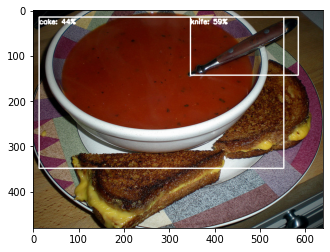

0 [0.765625   0.7421875  0.5859375  0.33203125 0.33203125 0.28125
 0.2578125  0.2578125  0.2578125  0.21484375]
1 [[ 3.0130059e-01  7.3348969e-02  5.8925897e-01  3.4623140e-01]
 [ 1.9436285e-02  3.8725746e-01  5.0084352e-01  9.3302226e-01]
 [ 5.9874654e-01  8.7766021e-02  8.3097374e-01  2.3434931e-01]
 [ 3.7108186e-01  1.8251240e-03  6.1467320e-01  8.3929852e-02]
 [ 3.3196330e-01  3.8998306e-02  6.8691778e-01  3.2184103e-01]
 [ 5.7376593e-01  4.3567625e-01  7.4396914e-01  1.0290436e+00]
 [ 4.9645621e-01  3.4819573e-01  6.3208133e-01  3.9557803e-01]
 [ 5.7437944e-01 -2.5441870e-04  7.0062065e-01  1.0912196e-01]
 [ 5.5703998e-01 -4.3953061e-03  9.7163999e-01  1.0055344e+00]
 [ 3.8192952e-01  3.2639197e-01  6.6816545e-01  3.9502308e-01]]
2 10.0
3 [72. 71. 46. 63. 72.  8. 46. 50. 66. 46.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


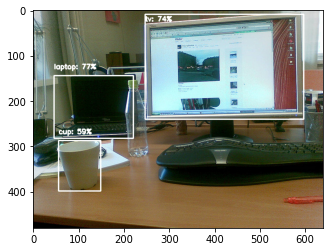

0 [0.85546875 0.44140625 0.44140625 0.3046875  0.3046875  0.28125
 0.28125    0.234375   0.234375   0.21484375]
1 [[ 0.48857868  0.24782687  0.9757613   0.49141818]
 [ 0.31589314  0.00890552  0.43410686  0.2968639 ]
 [ 0.29141027  0.18536896  0.45858973  0.7578408 ]
 [ 0.36647573  0.8291909   0.47984436  0.9993941 ]
 [ 0.3453165   0.7622531   0.4793338   1.0029567 ]
 [ 0.30685577 -0.00104373  0.3860692   0.09038369]
 [ 0.27679557  0.04941857  0.43334436  0.87365896]
 [ 0.30430758 -0.00471192  0.35998493  0.10466446]
 [ 0.3111731   0.00315334  0.44599685  0.43288642]
 [ 0.31082022  0.5745157   0.4750297   0.99661446]]
2 10.0
3 [10.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


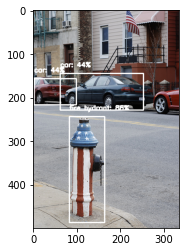

0 [0.53125    0.3828125  0.35546875 0.21484375 0.21484375 0.14453125
 0.1171875  0.1171875  0.10546875 0.09765625]
1 [[ 6.2684387e-02  5.6342170e-02  9.3769538e-01  4.9384767e-01]
 [ 3.6954284e-03  4.9565375e-01  9.1064459e-01  9.8283637e-01]
 [ 5.1531076e-02  1.0330051e-01  6.4846897e-01  4.0176946e-01]
 [ 2.6243664e-03  2.2548422e-01  1.0026032e-01  3.5712066e-01]
 [ 4.1762412e-02  3.6463335e-02  5.9739834e-01  3.1930608e-01]
 [ 3.9339975e-02  5.4002386e-01  4.3934000e-01  6.9563621e-01]
 [ 4.8489061e-01 -3.0115992e-04  5.7415664e-01  3.9068647e-02]
 [ 8.7152794e-04  4.1365303e-02  7.0326015e-02  1.9884452e-01]
 [ 9.9490732e-03  2.2327401e-01  7.3069692e-02  3.4290594e-01]
 [ 8.8410044e-01  9.7709522e-04  1.0016071e+00  5.9730411e-02]]
2 10.0
3 [ 0. 12.  0. 71.  0. 69. 48. 27. 71.  0.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


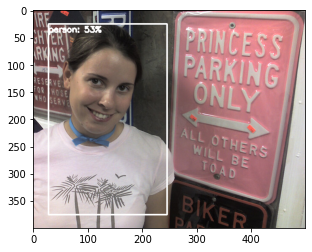

0 [0.66796875 0.64453125 0.6171875  0.44140625 0.3828125  0.33203125
 0.28125    0.2578125  0.234375   0.21484375]
1 [[0.5143663  0.011684   0.9957736  0.5288756 ]
 [0.3287707  0.28131384 0.45129925 0.34368616]
 [0.60532534 0.5207666  0.85481465 0.66218793]
 [0.16364333 0.7991734  0.42691627 0.9457566 ]
 [0.51245075 0.00254284 0.8274092  0.39308667]
 [0.21238911 0.81181294 0.40883607 0.92931956]
 [0.71268547 0.45156348 0.8301921  0.5082478 ]
 [0.48180273 0.13545409 0.540556   0.17435718]
 [0.6625451  0.0991118  1.0070353  0.5980905 ]
 [0.5946605  0.39370012 0.8339244  0.49922484]]
2 10.0
3 [64. 84. 61. 71. 64. 71. 14. 46. 64. 14.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


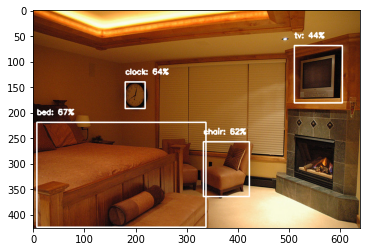

0 [0.5        0.2578125  0.2578125  0.234375   0.1953125  0.1796875
 0.16015625 0.16015625 0.14453125 0.14453125]
1 [[0.38501012 0.18095171 0.7295003  0.47411823]
 [0.40960428 0.56230503 0.5189806  0.6537325 ]
 [0.4409904  0.46418148 0.63051945 0.6571385 ]
 [0.39785343 0.2102524  0.70721656 0.5984887 ]
 [0.3909595  0.54287744 0.4840405  0.64287746]
 [0.4142431  0.5453347  0.553152   0.65938556]
 [0.41579777 0.57958657 0.49888748 0.6515761 ]
 [0.42652917 0.48731261 0.6413957  0.7985373 ]
 [0.40951312 0.4954877  0.5256268  0.6447221 ]
 [0.43930998 0.56157124 0.5749351  0.66522133]]
2 10.0
3 [21. 18. 18. 21. 18. 18. 18. 18. 18. 18.]
scores shape (10,)
classes shape (10,)
boxes shape (10, 4)


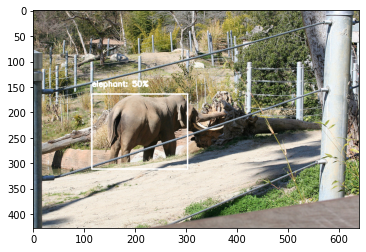

In [35]:
for i in imagePaths[1:1000]:
  test_tf_lite(interpreter, i, debugging = True)
  

In [36]:
# Load the TFLiteFloat16 model which used the full repr data for converting
interpreter = tf.lite.Interpreter(model_path=_TFLITE_MODEL_PATH_FULL_FLOAT16)
interpreter.allocate_tensors()

In [37]:
for i in imagePaths[1:1000]:
  test_tf_lite(interpreter, i, debugging = True)
  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Load the TFLiteFloat32 model which used the full repr data for converting
interpreter = tf.lite.Interpreter(model_path=_TFLITE_MODEL_PATH_FULL_FLOAT32)
interpreter.allocate_tensors()

In [ ]:
for i in imagePaths[1:1000]:
  test_tf_lite(interpreter, i, debugging = True)

#TO DO

1- Measure mAP s for each of the configurations ()

2- Plots 
*   Model Size (MB) vs Type of Network
*   Accuracy (mAP) vs Type of Network
*   Latency/Runtime (milli seconds) vs Type of Network

